In [1]:
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from keras.layers.convolutional import Cropping2D
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
            
def generate_data(lines, batch_size=32):
    num_lines = len(lines)
    while 1: # Loop forever so the generator never terminates
        shuffle(lines)
        #batch_pbar = tqdm(range(0, num_lines, batch_size), unit='batches')
        for offset in range(0, num_lines, batch_size):
            batch_lines = lines[offset:offset+batch_size]
            
            data = {'front_images': [], 'left_images': [], 'right_images': [], 
                'steering_angles_front': [], 'steering_angles_left': [], 'steering_angles_right': []}
            
            for line in batch_lines:
                front_filename = line[0].split('/')[-1]
                left_filename = line[1].split('/')[-1]
                right_filename = line[2].split('/')[-1]
                 
                #TODO: Tune this parameter, try 0.25
                steering_correction = 0.25
                  
                #TODO: Consider randomly dropping low (<0.05 abs) steering angles to reduce bias
                # With augmentation (flipped and steering_angle reversed)
                front_image = cv2.imread(IMG_DIR + front_filename)
                steering_angle = np.float(line[3])
                data['front_images'].append(front_image)
                data['front_images'].append(cv2.flip(front_image, 1))
                data['steering_angles_front'].append(steering_angle)
                data['steering_angles_front'].append(-1.0 * steering_angle)
                 
                left_image = cv2.imread(IMG_DIR + left_filename)
                steering_angle_left = np.float(line[3]) + steering_correction
                data['left_images'].append(left_image)
                data['left_images'].append(cv2.flip(left_image, 1))
                data['steering_angles_left'].append(steering_angle_left)
                data['steering_angles_left'].append(-1.0 * steering_angle_left)
                 
                right_image = cv2.imread(IMG_DIR + right_filename)
                steering_angle_right = np.float(line[3]) - steering_correction
                data['right_images'].append(right_image)
                data['right_images'].append(cv2.flip(right_image, 1))
                data['steering_angles_right'].append(steering_angle_right)
                data['steering_angles_right'].append(-1.0 * steering_angle_right)
            X_train = np.array(data['front_images'] + data['left_images'] + data['right_images'])
            y_train = np.array(data['steering_angles_front'] + data['steering_angles_left'] + data['steering_angles_right'])
            yield shuffle(X_train, y_train)
 
#################
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))
#################
# pickle_dump(data, "data.p")
# data = pickle_load("data.p")
# 
# print('Data creation/loading completed...')


IMG_DIR = './data/training/IMG/'
lines = []
with open('./data/training/driving_log.csv') as csvFile:
    reader = csv.reader(csvFile)
    for line in reader:
        lines.append(line) 

#lines = lines[:5]                  
train_lines, validation_lines = train_test_split(lines, test_size=0.2)
train_data_generator = generate_data(train_lines)
validation_data_generator = generate_data(validation_lines)


# TODO: Can't think of a way why testing data can be beneficial (cheating by testing in simulator anyways)
# X_train, X_test, y_train, y_test = train_test_split(
#     data['front_images'] + data['left_images'] + data['right_images'], 
#     data['steering_angles_front'] + data['steering_angles_left'] + data['steering_angles_right'], 
#     test_size=0.33, random_state = 42)
  
# X_train = data['front_images'] + data['left_images'] + data['right_images']
# y_train = data['steering_angles_front'] + data['steering_angles_left'] + data['steering_angles_right']
    
    

Using TensorFlow backend.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/Library/Frameworks/Python.framework/

Epoch 1/2
4/4 [==============================] - 2s - loss: 0.0229 - val_loss: 0.0709
Epoch 2/2
4/4 [==============================] - 1s - loss: 0.0282 - val_loss: 0.0233
Model saved!


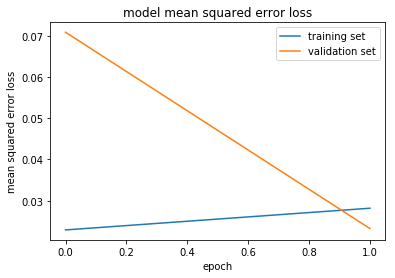

In [2]:
# Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
# Normalized data with zero mean
model.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
#model.fit(np.array(X_train), np.array(y_train), validation_split=0.2, shuffle=True, nb_epoch=3)
history_object = model.fit_generator(train_data_generator, samples_per_epoch= \
                    len(train_lines), validation_data=validation_data_generator, \
                    nb_val_samples=len(validation_lines), nb_epoch=3)
model.save('model.h5')
print('Model saved!')

# Visualize
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()